In [1]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True

img_wh = (200, 200)

dataset = dataset_dict['blender'] \
          ('./data/nerf_synthetic/hand_grasp/', 'train',
           img_wh=img_wh)

d:\miniconda3\envs\nerf_pl\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = './ckpts/hand_flat_4/epoch=7.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [3]:
from models.reandering_trans import render_rays_trans
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4

@torch.no_grad()
def f_trans(rays, poses = None, mano_layer = None):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays_trans(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True,
                        poses=poses,
                        mano_layer=mano_layer)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results


def f_trans_train(rays, poses = None, mano_layer = None):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays_trans(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True,
                        poses=poses,
                        mano_layer=mano_layer)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [4]:
from mano.manolayer import ManoLayer

ncomps = 45
poses = torch.zeros(1, ncomps + 3, dtype=torch.float32, requires_grad=True)
# poses = torch.ones(1, ncomps + 3, dtype=torch.float32, requires_grad=True)
mano_layer = ManoLayer(mano_root='./mano/models', use_pca=False, ncomps=ncomps, flat_hand_mean=True)
shapes = torch.zeros(1, 10)

e:\WorkSpace\nerf_pl\mano\manolayer.py:67: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:178.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


In [5]:
from tqdm import tqdm
epochs = 20
rounds = 200

length = 200 * 200
batch_size = 1024
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam([poses], lr=4e-3)

for epoch in range(epochs):
    img_idx = torch.randint(low=0, high=100, size=(1, ))
    tr = tqdm(range(rounds))
    tr.set_description(f'Epoch {epoch}:')
    for round in tr:
        idx = torch.randint(low=0, high=length, size=(batch_size,)) + img_idx * length
        idx = idx.numpy()
        sample = dataset[idx]
        rays = sample['rays'].cuda()
        
        results = f_trans_train(rays, poses, mano_layer)
        results['rgb_fine'].data = torch.nan_to_num(results['rgb_fine'])

        optimizer.zero_grad()
        loss_val = loss(results['rgb_fine'], sample['rgbs'].cuda())
        loss_val.backward()
        tr.set_postfix({'loss': loss_val.item()})
        optimizer.step()
        result_poses = poses


print(result_poses)

Epoch 0::   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 19:: 100%|██████████| 200/200 [03:25<00:00,  1.03s/it, loss=0.00473]

tensor([[ 0.0064,  0.0087,  0.0116,  0.1811, -0.3244,  0.6197, -0.3260, -0.9196,
         -0.0183,  0.6432, -0.2731, -0.0650, -0.2928, -0.1635,  0.5203,  0.1632,
         -1.7470,  0.2746, -0.3355, -1.0696,  0.1828, -0.7606,  0.3760,  0.5286,
         -0.0965,  0.3643, -0.0803,  0.2662, -0.1564, -0.0420, -0.8258, -0.1718,
          0.6351, -1.9138, -0.3245, -1.7020, -0.7090,  2.6433, -0.4007,  0.3986,
         -0.4954,  0.2918, -0.2438, -0.0029,  0.3089, -0.1753, -0.3339, -0.0228]],
       requires_grad=True)


In [6]:
path = './objects/'
def toObj(vertices, faces, filename='hand.obj', normalize=True):
    if normalize:
        min_x = min(vertices[:, 0])
        max_x = max(vertices[:, 0])
        min_y = min(vertices[:, 1])
        max_y = max(vertices[:, 1])
        min_z = min(vertices[:, 2])
        max_z = max(vertices[:, 2])

        scale = max(max_x - min_x, max_y - min_y, max_z - min_z)

        vertices[:, 0] = (vertices[:, 0] - min_x) * 2 / scale - 1.
        vertices[:, 1] = (vertices[:, 1] - min_y) * 2 / scale - 1.
        vertices[:, 2] = (vertices[:, 2] - min_z) * 2 / scale - 1.

    with open(path + filename, 'w') as f:
        for v in vertices:
            f.write('v %f %f %f\n' % (v[0], v[1], v[2]))

        for face in faces:
            f.write('f %d %d %d\n' % (face[0] + 1, face[1] + 1, face[2] + 1))

In [7]:
vertices, _, _ = mano_layer(result_poses, shapes)

toObj(vertices[0] * 12, mano_layer.th_faces, filename='hand_train.obj', normalize=False)

In [8]:
sample = dataset[:40000]
rays = sample['rays'].cuda()

t = time.time()
results = f_trans(rays, poses, mano_layer)
torch.cuda.synchronize()
print(time.time()-t)

34.066672563552856


PSNR 19.530353546142578


C:\Users\shapi\AppData\Local\Temp\ipykernel_1824\3342497830.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


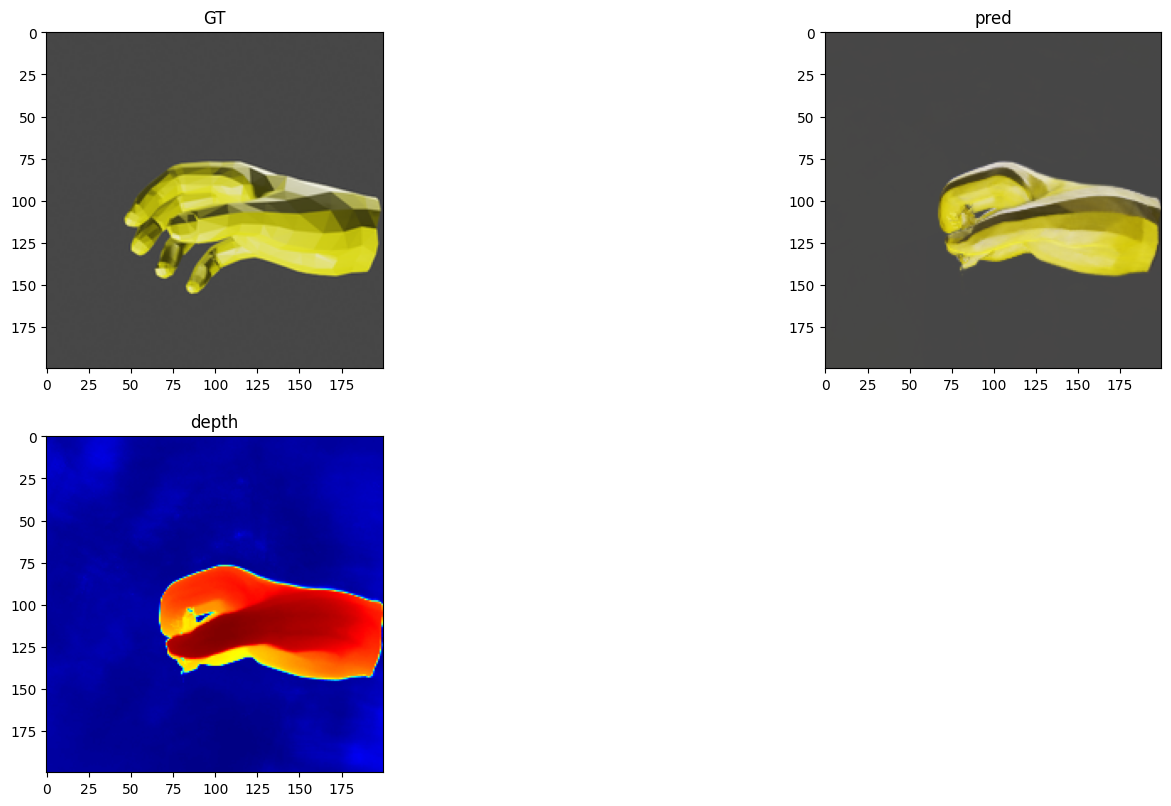

In [9]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()